In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 150

In [5]:
import numpy as np
import pandas as pd

import ipywidgets as widgets
from ipywidgets import interact, fixed


# Data
# from transat.data import HYPOTHETICAL_SUBMISSION_DATE
from transat.data.load import download_historical, load_historical
from transat.data.split import split_historical
from transat.data.transform import preprocess_historical_basic, dataframe_to_array

# Metric
from transat.metric import mae

# Scenario/Simulation
from transat.data.scenario import generate_scenario

In [6]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
HYPOTHETICAL_SUBMISSION_DATE = np.datetime64("2020-09-30")

In [8]:
download_historical()
df = load_historical()

In [9]:
df.columns

Index(['CountryName', 'CountryCode', 'RegionName', 'RegionCode',
       'Jurisdiction', 'Date', 'C1_School closing', 'C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6_Facial Coverings', 'H6_Flag', 'H7_Vaccination policy', 'H7_Flag',
       'M1_Wildcard', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'StringencyIndexForDisplay', 'StringencyLegacyIndex',
       'StringencyLegacyIndexForDispla

In [10]:
df = preprocess_historical_basic(df)

In [11]:
which_columns = df.columns

for col_name in which_columns:
    if df[col_name].isnull().values.any():
        print(f"'{col_name}' has NaN")

'RegionName' has NaN


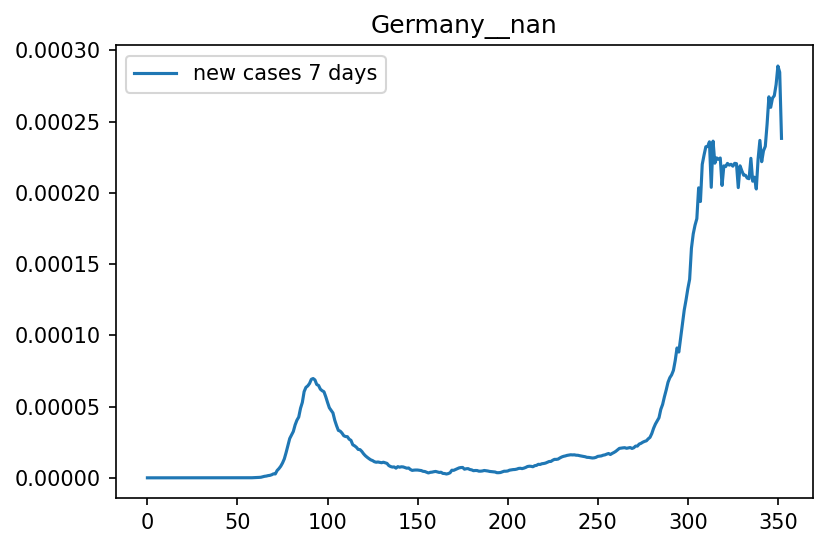

In [13]:
plt.figure()
geo_id = "Germany__nan"

plt.title(geo_id)

nc = df[df.GeoID == geo_id].NewCases.tolist()
nc7days = df[df.GeoID == geo_id].NewCasesSmoothed7Days.tolist()

# plt.plot(nc, label="new cases")
plt.plot(nc7days, label="new cases 7 days")
plt.legend()
plt.show()

In [14]:
print("Spliting at : ", HYPOTHETICAL_SUBMISSION_DATE)
df_train, df_test = split_historical(df, HYPOTHETICAL_SUBMISSION_DATE)

Spliting at :  2020-09-30


In [15]:
nb_lookback_days = 30
nb_lookahead_days = 7
sequence_format = True
neg_npis = False

(X_train, y_train), (X_cols, y_col) = dataframe_to_array(df_train, nb_lookback_days=nb_lookback_days, 
    nb_lookahead_days=nb_lookahead_days, sequence_format=sequence_format, neg_npis=neg_npis)
(X_test, y_test), _ = dataframe_to_array(df_test, nb_lookback_days=nb_lookback_days,
    nb_lookahead_days=nb_lookahead_days, sequence_format=sequence_format, neg_npis=neg_npis)

# X_train, y_train = X_train.reshape(X_train.shape[0], -1), y_train.reshape(-1)
# X_test, y_test = X_test.reshape(X_test.shape[0], -1), y_test.reshape(-1)

print("X_train shape: ", np.shape(X_train))
print("y_train shape: ", np.shape(y_train))
print()
print("X_test  shape: ", np.shape(X_test))
print("y_test  shape: ", np.shape(y_test))

X_train shape:  (55932, 30, 13)
y_train shape:  (55932, 7, 1)

X_test  shape:  (9717, 30, 13)
y_test  shape:  (9717, 7, 1)


In [146]:
class LSTM:
        
    def fit(self, X, y, X_valid, y_valid, epochs=1, batch_size=32):
        
        # Build Model
        if not(hasattr(self, "model")):
            input_shape = X.shape[1:]
            self.model = self.build_model(input_shape)
            
        # Pre-process data
        self.fit_preprocess(X, y)
        X, y = self.transform(X, y)
        X_valid, y_valid = self.transform(X_valid, y_valid)
        
        # callbacks
        
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.8, patience=5, verbose=1,
            mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
        )
        
        # Fit Model
        history = self.model.fit(X, y, 
            epochs=epochs, 
            batch_size=batch_size,
            validation_data=(X_valid, y_valid),
            callbacks=[reduce_lr],
            shuffle=True,
        )
        
        return history
        
    def predict(self, X):
        X = self.transform(X)
        
        y = self.model.predict(X).reshape(-1)
        print("predict: ", y)
        
        # Inverse preprocessing
#         y = y * self.std[0] + self.mean[0]
        y = y * (self.max[0] - self.min[0]) + self.min[0]
        print("predict: ", y)
        
        return y
    
    def fit_preprocess(self, X, y):
        # MinMax (x - min) / (max - min)
        self.min = X.reshape(-1, X.shape[-1]).min(axis=0)
        self.max = X.reshape(-1, X.shape[-1]).max(axis=0)

        # Normalization
#         self.mean = X.reshape(-1, X.shape[-1]).mean(axis=0)
#         self.std = X.reshape(-1, X.shape[-1]).std(axis=0)

        
    
    
    def transform(self, X, y=None):
        X = (X - self.min) / (self.max - self.min)
#         X = (X - self.mean) / self.std
        if y is not None:
            y = (y - self.min[0]) / (self.max[0] - self.min[0])
#             y = (y - self.mean[0]) / self.std[0]
            return X, y
        else:
            return X
    
    def build_model(self, input_shape):

        input = tf.keras.Input(shape=input_shape, name='input')
#         x = tf.keras.layers.Conv1D(32, 3, activation='relu')(input)
#         x = tf.keras.layers.Conv1D(16, 3, activation='relu')(x)
#         x = tf.keras.layers.Flatten()(input)
        x = tf.keras.layers.LSTM(32, return_sequences=False)(input)
#         x = tf.keras.layers.LSTM(32, return_sequences=False)(x)
#         x = tf.keras.layers.GRU(128)(input)
#         x = tf.keras.layers.Dense(64, activation='relu')(x)
#         x = tf.keras.layers.Dense(64, activation='sigmoid', kernel_constraint=tf.keras.constraints.UnitNorm(axis=0))(x)
#         x = tf.keras.layers.Dense(32, activation='sigmoid', kernel_constraint=tf.keras.constraints.UnitNorm(axis=0))(x)
#         x = tf.keras.layers.Dense(16, activation='sigmoid', kernel_constraint=tf.keras.constraints.UnitNorm(axis=0))(x)
#         x = tf.keras.layers.Dense(32, activation='relu')(x)
#         x = tf.keras.layers.Dense(32, activation='relu')(x)
#         x = tf.keras.layers.Dense(32, activation='relu')(x)
        output = tf.keras.layers.Dense(7, activation=None, name='output')(x)
        model = tf.keras.Model(inputs=[input], outputs=[output])

        model.compile(
#             loss=tf.losses.MeanSquaredError(),
            loss=tf.keras.losses.MeanAbsoluteError(),
#             loss=tf.keras.losses.LogCosh(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.metrics.MeanAbsoluteError()]
        )

        return model
    
model = LSTM()

In [147]:
hist = model.fit(X_train, y_train, X_test, y_test, epochs=1).history

2258/2258 [==============================] - 5s 2ms/step - loss: 0.0069 - mean_absolute_error: 0.0069 - val_loss: 0.0085 - val_mean_absolute_error: 0.0085 - lr: 0.0010


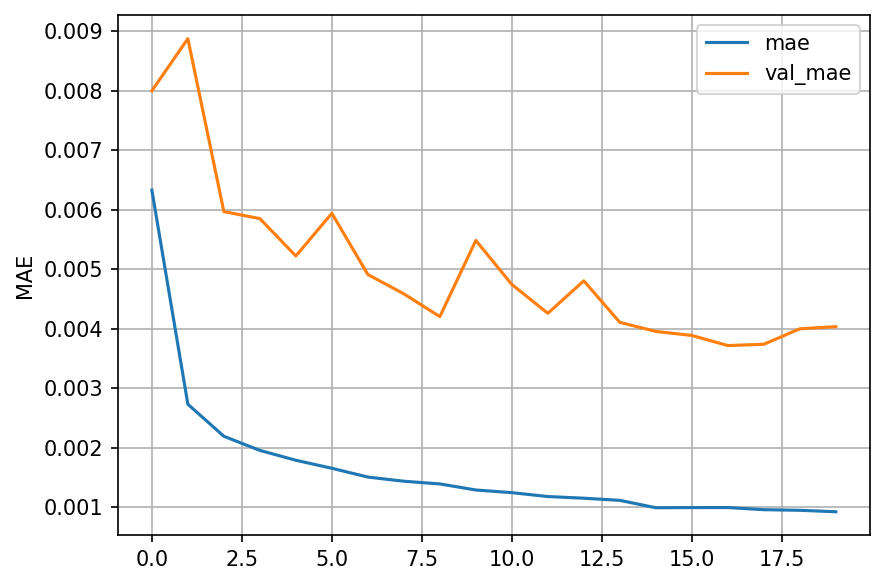

In [128]:
plt.figure()

plt.ylabel("MAE")
plt.plot(hist["mean_absolute_error"], label="mae")
plt.plot(hist["val_mean_absolute_error"], label="val_mae")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [145]:
# Evaluate model
# train_preds = model.predict(X_train)
# train_preds = np.maximum(train_preds, 0) # Don't predict negative cases
# print('Train MAE:', mae(train_preds, y_train))

# valid_preds = model.predict(X_valid)
# valid_preds = np.maximum(valid_preds, 0) # Don't predict negative cases
# print('Valid MAE:', mae(valid_preds, y_valid))

test_preds = model.predict(X_test)
test_preds = np.maximum(test_preds, 0) # Don't predict negative cases

print('Test MAE:', mae(test_preds, y_test.reshape(-1)))

predict:  [-6.5217260e-05 -6.5217260e-05 -6.5217260e-05 ...  4.2552827e-04
  3.3165095e-04  2.5309599e-04]
Test MAE: 373.817755940752


In [130]:
mean_variation = X_test[:,:,0].mean(axis=1)
variation_threshold = 100
test_preds[mean_variation < variation_threshold] = mean_variation[mean_variation < variation_threshold]
print('Test MAE:', mae(test_preds, y_test.reshape(-1)))

Test MAE: 368.3942544468679


In [139]:
model.model.save_weights("weights.h5")

In [148]:
model.model.load_weights("weights.h5")

In [131]:
def simulate_scenario(model, X_scenario, y_scenario, seq=False):
    # Simulate scenario

    X_sim = X_scenario.copy()
    X_sim_cases = X_sim[:,:,:1]
    X_sim_npis = X_sim[:,:,1:]
    y_sim = np.zeros(np.shape(y_scenario))

    nb_lookback_days = X_sim.shape[1]

    for d in range(y_sim.shape[1]):
        
        if seq:
            y = model.predict(X_sim)
        else:
            y = model.predict(X_sim.reshape(1,-1))
        y_sim[0,d,0] = max(y[0], 0)

        # Assuming constant NPIs here
        X_sim_npis = np.concatenate([X_sim_npis[:,1:], X_sim_npis[:,-1:]], axis=1)
        X_sim_cases = np.concatenate([X_sim_cases[:,1:], y.reshape(-1, 1, 1)], axis=1)

        X_sim =  np.concatenate([X_sim_cases, X_sim_npis], axis=-1)
        X_sim = np.array(X_sim)
    
    return y_sim

In [132]:
# def simulate_scenario(model, X_scenario, y_scenario, seq=False):
#     # Simulate scenario

#     X_sim = X_scenario.copy()
#     X_sim_cases = X_sim[:,:,:1]
#     X_sim_npis = X_sim[:,:,1:]
#     y_sim = np.zeros(np.shape(y_scenario))

#     nb_lookback_days = X_sim.shape[1]
    
#     y_sim = model.predict(X_sim)
    
#     return y_sim

In [133]:
def viz_scenario(geo_id, X_scenario, y_scenario, y_sim):
    mae_error = mae(y_scenario, y_sim)

    plt.figure()
    plt.title(geo_id)

    plot_input_x = np.arange(X_scenario.shape[1])
    plot_input_y = X_scenario[:,:,:1].reshape(-1)

    plt.plot(plot_input_x, plot_input_y, label="Input Scenario")

    plot_output_x = np.arange(y_scenario.shape[1])+X_scenario.shape[1]
    plot_output_x = np.concatenate([plot_input_x[-1:], plot_output_x])
    plot_output_y = np.concatenate([plot_input_y[-1:], y_scenario.reshape(-1)])
    plt.plot(plot_output_x, plot_output_y, label="Output Scenario")


    plot_output_y = np.concatenate([plot_input_y[-1:], y_sim.reshape(-1)])
    plt.plot(plot_output_x, plot_output_y, label="Output Simulation")

    plt.ylabel("New Cases")
    plt.xlabel("Days")
    ax = plt.gca()
    plt.text(0.3, 0.5, f"$MAE={mae_error:.2f}$", transform=ax.transAxes)
    plt.legend()
    plt.show()

In [149]:
def interactive_scenario(geo_id, model, seq=True):
    nb_future_days=21

    X_scenario , y_scenario = generate_scenario(df_train, df_test, geo_id, nb_lookback_days=nb_lookback_days,
        nb_future_days=nb_future_days, sequence_format=sequence_format)
    y_sim = simulate_scenario(model, X_scenario, y_scenario, seq=seq)
    
    mean_variation = X_scenario[:,:,0].reshape(-1).mean()
    print(mean_variation)
    print(X_scenario[:,:,0].reshape(-1))
    print(y_sim.reshape(-1))
    variation_threshold = 1
    if mean_variation < variation_threshold:
        y_sim[:] = mean_variation
    viz_scenario(geo_id, X_scenario, y_scenario, y_sim)
    
geo_ids = sorted(df.GeoID.unique())

w_geo_id = widgets.Dropdown(
    options=geo_ids,
    value='France__nan',
    description='GeoID:',
    disabled=False
)

interact(interactive_scenario, geo_id=w_geo_id, model=fixed(model), seq=fixed(True))

interactive(children=(Dropdown(description='GeoID:', index=100, options=('Afghanistan__nan', 'Albania__nan', '…

<function __main__.interactive_scenario(geo_id, model, seq=True)>

In [150]:
model.min[0]

0.0

In [151]:
model.max[0]

93198.57142857143